Set up the environment

In [1]:
from __future__ import division

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

Read in the data

In [2]:
fifa = pd.read_csv('../data/CompleteDataset.csv', index_col=0)

C:\Users\aluz\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
fifa.shape

(17981, 74)

In [4]:
fifa.head()

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
fifa.shape

(17981, 74)

In [6]:
fifa.isnull().sum()[fifa.isnull().sum() > 0]

Club     248
CAM     2029
CB      2029
CDM     2029
CF      2029
CM      2029
LAM     2029
LB      2029
LCB     2029
LCM     2029
LDM     2029
LF      2029
LM      2029
LS      2029
LW      2029
LWB     2029
RAM     2029
RB      2029
RCB     2029
RCM     2029
RDM     2029
RF      2029
RM      2029
RS      2029
RW      2029
RWB     2029
ST      2029
dtype: int64

Create df with just the abilities

In [7]:
fifa_abilities = fifa.loc[:, 'Acceleration':'Volleys'].columns.values

fifa[fifa_abilities].dtypes

Acceleration          object
Aggression            object
Agility               object
Balance               object
Ball control          object
Composure             object
Crossing              object
Curve                 object
Dribbling             object
Finishing             object
Free kick accuracy    object
GK diving             object
GK handling           object
GK kicking            object
GK positioning        object
GK reflexes           object
Heading accuracy      object
Interceptions         object
Jumping               object
Long passing          object
Long shots            object
Marking               object
Penalties             object
Positioning           object
Reactions             object
Short passing         object
Shot power            object
Sliding tackle        object
Sprint speed          object
Stamina               object
Standing tackle       object
Strength              object
Vision                object
Volleys               object
dtype: object

They are strings so we need to convert them to integers. Some players have abilities like this "74+2" so in order to convert that string to an integer we first need to just keep the first 2 digits

In [8]:
fifa[fifa_abilities].sample(n=5, random_state=5)

,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
4549,83,63,87,83,68,70,58,70,78,66,...,69,68,72,43,77,74,51,48,65,61
13830,44,37,57,42,15,23,15,13,14,10,...,59,28,25,14,45,18,14,62,15,8
4164,77,51,81,83,75,76,70,65,72,58-1,...,66-1,76,68,64,73,68-2,67-1,58,74-2,48
3427,43,80,36,33,54,54,30,25,46,30,...,65,57,50,68,47,78,72,84,49,28
12506,89,54,92,62,64,70,49,37,62,56,...,67,61,61,28,91,56,27,57,56,46


In [9]:
# we're actually gonna add or substract what's after the sign to/from what's before the sign
for col in fifa_abilities:
    for i, row in enumerate(fifa[col]):
        if '+' in str(row):
            a = fifa.loc[fifa.index == i, col].apply(lambda x: str(x)[:2])
            b = fifa.loc[fifa.index == i, col].apply(lambda x: str(x)[3:])
            new = str(int(a) + int(b))
            fifa.loc[fifa.index == i, col] = new
        elif '-' in str(row):
            a = fifa.loc[fifa.index == i, col].apply(lambda x: str(x)[:2])
            b = fifa.loc[fifa.index == i, col].apply(lambda x: str(x)[3:])
            new = str(int(a) - int(b))
            fifa.loc[fifa.index == i, col] = new
    fifa[col] = fifa[col].astype('int')

In [10]:
fifa[fifa_abilities].sample(n=5, random_state=5)

,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
4549,83,63,87,83,68,70,58,70,78,66,...,69,68,72,43,77,74,51,48,65,61
13830,44,37,57,42,15,23,15,13,14,10,...,59,28,25,14,45,18,14,62,15,8
4164,77,51,81,83,75,76,70,65,72,57,...,65,76,68,64,73,66,66,58,72,48
3427,43,80,36,33,54,54,30,25,46,30,...,65,57,50,68,47,78,72,84,49,28
12506,89,54,92,62,64,70,49,37,62,56,...,67,61,61,28,91,56,27,57,56,46


In [11]:
fifa[fifa_abilities].dtypes

Acceleration          int32
Aggression            int32
Agility               int32
Balance               int32
Ball control          int32
Composure             int32
Crossing              int32
Curve                 int32
Dribbling             int32
Finishing             int32
Free kick accuracy    int32
GK diving             int32
GK handling           int32
GK kicking            int32
GK positioning        int32
GK reflexes           int32
Heading accuracy      int32
Interceptions         int32
Jumping               int32
Long passing          int32
Long shots            int32
Marking               int32
Penalties             int32
Positioning           int32
Reactions             int32
Short passing         int32
Shot power            int32
Sliding tackle        int32
Sprint speed          int32
Stamina               int32
Standing tackle       int32
Strength              int32
Vision                int32
Volleys               int32
dtype: object

### Preferred Positions
Some players have more than one preferred position. We want to end up with 4 (GK, D, M, A) or 6 (GK, D, MD, M, MA, A) categories. We have 2 options:

- **Simple:** Keep the 1st preferred position. e.g. K. De Bruyne has RM CM CAM, we assign RM, which would then get mapped to M as per the below mapping.

        'CB': 'D',
        'ST': 'A',
        'GK': 'GK',
        'CM': 'M',
        'CDM': 'M',
        'RM': 'M',
        'LM': 'M',
        'LB': 'D',
        'RB': 'D',
        'CAM': 'M',
        'RW': 'A',
        'LW': 'A',
        'CF': 'A',
        'LWB': 'D',
        'RWB': 'D'
        
- **Complex:** We try to build a model to predict what category each player belongs too (GK, D, MD, M, MA, A) based on the player's abilities and preferred positions. For this, we'll have to manually label at least 50 examples.

In [12]:
fifa[['Name', 'Preferred Positions']].head(50).sample(n=5)

,Name,Preferred Positions
42,David Silva,LM CM CAM
48,Isco,LM RM CAM CM
24,L. Bonucci,CB
49,D. Alaba,CM CB LB
30,Thiago Silva,CB


In [13]:
fifa.columns

Index([u'Name', u'Age', u'Photo', u'Nationality', u'Flag', u'Overall',
       u'Potential', u'Club', u'Club Logo', u'Value', u'Wage', u'Special',
       u'Acceleration', u'Aggression', u'Agility', u'Balance', u'Ball control',
       u'Composure', u'Crossing', u'Curve', u'Dribbling', u'Finishing',
       u'Free kick accuracy', u'GK diving', u'GK handling', u'GK kicking',
       u'GK positioning', u'GK reflexes', u'Heading accuracy',
       u'Interceptions', u'Jumping', u'Long passing', u'Long shots',
       u'Marking', u'Penalties', u'Positioning', u'Reactions',
       u'Short passing', u'Shot power', u'Sliding tackle', u'Sprint speed',
       u'Stamina', u'Standing tackle', u'Strength', u'Vision', u'Volleys',
       u'CAM', u'CB', u'CDM', u'CF', u'CM', u'ID', u'LAM', u'LB', u'LCB',
       u'LCM', u'LDM', u'LF', u'LM', u'LS', u'LW', u'LWB',
       u'Preferred Positions', u'RAM', u'RB', u'RCB', u'RCM', u'RDM', u'RF',
       u'RM', u'RS', u'RW', u'RWB', u'ST'],
      dtype='object')

In [14]:
# decide which way you want to do it
x = raw_input('Simple (s) or complex (c)? > ')

Simple (s) or complex (c)? > c


In [15]:
if x == 's':
    fifa['Preferred Position'] = fifa['Preferred Positions'].str.split(' ').apply(lambda x: x[0])
    fifa['Preferred Position'] = fifa['Preferred Position'].map({
        'CB': 'D',
        'ST': 'A',
        'GK': 'GK',
        'CM': 'M',
        'CDM': 'DM',
        'RM': 'M',
        'LM': 'M',
        'LB': 'D',
        'RB': 'D',
        'CAM': 'AM',
        'RW': 'A',
        'LW': 'A',
        'CF': 'A',
        'LWB': 'D',
        'RWB': 'D'
    })
    
elif x == 'c':
    temp = fifa[fifa_abilities]
    temp2 = pd.concat([fifa[['Name', 'Preferred Positions']], temp], axis=1)
    positions = temp2['Preferred Positions'].str.split().apply(lambda x: x[0]).value_counts().index.values

    # for each position
    for pos in positions:
        # create an empty column with the name of the position
        temp2[pos] = np.nan
        # if the position is in the preferred positions column, put 1
        temp2.loc[temp2['Preferred Positions'].str.contains(pos), pos] = 1
        # if not, put 0
        temp2[pos].fillna(0, inplace=True)
    
    temp2['Preferred Position'] = np.nan
    
    def assign_position(df, name, pos):
        df.loc[df.Name == name, 'Preferred Position'] = pos
        return df
    
    assign_position(temp2, 'Cristiano Ronaldo', 'A')
    assign_position(temp2, 'L. Messi', 'A')
    assign_position(temp2, 'Neymar', 'A')
    assign_position(temp2, 'L. Suárez', 'A')
    assign_position(temp2, 'M. Neuer', 'GK')
    assign_position(temp2, 'R. Lewandowski', 'A')
    assign_position(temp2, 'De Gea', 'GK')
    assign_position(temp2, 'E. Hazard', 'A')
    assign_position(temp2, 'T. Kroos', 'DM')
    assign_position(temp2, 'G. Higuaín', 'A')
    assign_position(temp2, 'Sergio Ramos', 'D')
    assign_position(temp2, 'K. De Bruyne', 'AM')
    assign_position(temp2, 'T. Courtois', 'GK')
    assign_position(temp2, 'A. Sánchez', 'A')
    assign_position(temp2, 'L. Modrić', 'AM')
    assign_position(temp2, 'G. Bale', 'A')
    assign_position(temp2, 'S. Agüero', 'A')
    assign_position(temp2, 'G. Chiellini', 'D')
    assign_position(temp2, 'G. Buffon', 'GK')
    assign_position(temp2, 'P. Dybala', 'A')
    assign_position(temp2, 'J. Oblak', 'GK')
    assign_position(temp2, 'A. Griezmann', 'A')
    assign_position(temp2, 'Thiago', 'AM')
    assign_position(temp2, 'P. Aubameyang', 'A')
    assign_position(temp2, 'L. Bonucci', 'D')
    assign_position(temp2, 'J. Boateng', 'D')
    assign_position(temp2, 'D. Godín', 'D')
    assign_position(temp2, 'M. Hummels', 'D')
    assign_position(temp2, 'M. Özil', 'AM')
    assign_position(temp2, 'H. Lloris', 'GK')
    assign_position(temp2, 'Thiago Silva', 'D')
    assign_position(temp2, 'Z. Ibrahimović', 'A')
    assign_position(temp2, 'A. Robben', 'A')
    assign_position(temp2, 'N. Kanté', 'DM')
    assign_position(temp2, 'M. Verratti', 'AM')
    assign_position(temp2, 'P. Pogba', 'DM')
    assign_position(temp2, 'C. Eriksen', 'AM')
    assign_position(temp2, 'A. Vidal', 'DM')
    assign_position(temp2, 'E. Cavani', 'A')
    assign_position(temp2, 'Marcelo', 'D')
    assign_position(temp2, 'M. Hamšík', 'AM')
    assign_position(temp2, 'I. Rakitić', 'AM')
    assign_position(temp2, 'David Silva', 'AM')
    assign_position(temp2, 'S. Handanovič', 'GK')
    assign_position(temp2, 'Piqué', 'D')
    assign_position(temp2, 'Iniesta', 'AM')
    assign_position(temp2, 'H. Kane', 'A')
    assign_position(temp2, 'J. Rodríguez', 'A')
    assign_position(temp2, 'Isco', 'AM')
    assign_position(temp2, 'D. Alaba', 'D')
    
    temp2['Preferred Position'] = temp2['Preferred Position'].map({
            'A': 1,
            'AM': 2,
            'DM': 3,
            'D': 4,
            'GK': 5
        })
    
    X = temp2.loc[:, 'CB': 'RWB'].copy()
    y = temp2['Preferred Position']
    
    kf = StratifiedKFold(n_splits=3)
    
    pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression())
        ])
    
    gs = GridSearchCV(pipe, param_grid={
            'clf__C': np.logspace(-10, 2, 13)
        }, scoring='accuracy', cv=kf)
    
    scores = cross_val_score(gs, X.head(50), y.head(50), scoring='accuracy', cv=kf)
    print np.mean(scores)
    
    gs.fit(X.head(50), y.head(50))
    
    preds = pd.Series(gs.predict(X))
    fifa['Preferred Position'] = preds
    
    fifa['Preferred Position'] = fifa['Preferred Position'].map({
            1: 'A',
            2: 'AM',
            3: 'DM',
            4: 'D',
            5: 'GK'
        })

C:\Users\aluz\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.877412280702


In [16]:
fifa.columns

Index([u'Name', u'Age', u'Photo', u'Nationality', u'Flag', u'Overall',
       u'Potential', u'Club', u'Club Logo', u'Value', u'Wage', u'Special',
       u'Acceleration', u'Aggression', u'Agility', u'Balance', u'Ball control',
       u'Composure', u'Crossing', u'Curve', u'Dribbling', u'Finishing',
       u'Free kick accuracy', u'GK diving', u'GK handling', u'GK kicking',
       u'GK positioning', u'GK reflexes', u'Heading accuracy',
       u'Interceptions', u'Jumping', u'Long passing', u'Long shots',
       u'Marking', u'Penalties', u'Positioning', u'Reactions',
       u'Short passing', u'Shot power', u'Sliding tackle', u'Sprint speed',
       u'Stamina', u'Standing tackle', u'Strength', u'Vision', u'Volleys',
       u'CAM', u'CB', u'CDM', u'CF', u'CM', u'ID', u'LAM', u'LB', u'LCB',
       u'LCM', u'LDM', u'LF', u'LM', u'LS', u'LW', u'LWB',
       u'Preferred Positions', u'RAM', u'RB', u'RCB', u'RCM', u'RDM', u'RF',
       u'RM', u'RS', u'RW', u'RWB', u'ST', u'Preferred Position'],
    

In [17]:
temp2.columns

Index([u'Name', u'Preferred Positions', u'Acceleration', u'Aggression',
       u'Agility', u'Balance', u'Ball control', u'Composure', u'Crossing',
       u'Curve', u'Dribbling', u'Finishing', u'Free kick accuracy',
       u'GK diving', u'GK handling', u'GK kicking', u'GK positioning',
       u'GK reflexes', u'Heading accuracy', u'Interceptions', u'Jumping',
       u'Long passing', u'Long shots', u'Marking', u'Penalties',
       u'Positioning', u'Reactions', u'Short passing', u'Shot power',
       u'Sliding tackle', u'Sprint speed', u'Stamina', u'Standing tackle',
       u'Strength', u'Vision', u'Volleys', u'CB', u'ST', u'GK', u'CM', u'CDM',
       u'RM', u'LM', u'LB', u'RB', u'CAM', u'RW', u'LW', u'CF', u'LWB', u'RWB',
       u'Preferred Position'],
      dtype='object')

In [18]:
# this is just to get the below table for the blog post - ignore
names_ = ['A. Sánchez', 'Cristiano Ronaldo', 'P. Pogba', 'G. Bale', 'L. Modrić']
testy = temp2.loc[temp2.Name.isin(names_), ['Name', 'Preferred Positions']].copy()
testo = temp2.loc[temp2.Name.isin(names_), 'CB':'RWB'].copy()
teste = pd.concat([testy, testo], axis=1)
for col in teste.select_dtypes(['float']):
    teste[col] = teste[col].astype('int')
teste.head()

,Name,Preferred Positions,CB,ST,GK,CM,CDM,RM,LM,LB,RB,CAM,RW,LW,CF,LWB,RWB
0,Cristiano Ronaldo,ST LW,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
13,A. Sánchez,RM LW ST LM,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0
14,L. Modrić,CDM CM,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
15,G. Bale,RW,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
35,P. Pogba,CDM CM,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [19]:
fifa.sample(n=10)

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,Preferred Position
15595,K. Bigler,24,https://cdn.sofifa.org/48/18/players/205075.png,Switzerland,https://cdn.sofifa.org/flags/47.png,58,64,FC Thun,https://cdn.sofifa.org/24/18/teams/1715.png,€150K,...,58.0,54.0,57.0,53.0,55.0,52.0,53.0,58.0,52.0,AM
8756,F. Rherras,24,https://cdn.sofifa.org/48/18/players/228348.png,Morocco,https://cdn.sofifa.org/flags/129.png,67,71,KV Mechelen,https://cdn.sofifa.org/24/18/teams/110724.png,€825K,...,65.0,60.0,62.0,63.0,64.0,64.0,64.0,66.0,64.0,D
16950,P. Cunningham,20,https://cdn.sofifa.org/48/18/players/226016.png,Republic of Ireland,https://cdn.sofifa.org/flags/25.png,55,65,Galway United,https://cdn.sofifa.org/24/18/teams/1571.png,€150K,...,34.0,43.0,34.0,52.0,49.0,54.0,51.0,37.0,54.0,A
16541,J. Díaz,19,https://cdn.sofifa.org/48/18/players/241022.png,Argentina,https://cdn.sofifa.org/flags/52.png,56,69,Estudiantes de La Plata,https://cdn.sofifa.org/24/18/teams/101083.png,€150K,...,55.0,37.0,47.0,36.0,37.0,38.0,36.0,49.0,38.0,D
11168,Douglas Tanque,23,https://cdn.sofifa.org/48/18/players/220735.png,Brazil,https://cdn.sofifa.org/flags/54.png,64,70,Albirex Niigata,https://cdn.sofifa.org/24/18/teams/112906.png,€625K,...,45.0,49.0,42.0,57.0,52.0,63.0,54.0,41.0,63.0,A
11489,G. Scamacca,18,https://cdn.sofifa.org/48/18/players/226710.png,Italy,https://cdn.sofifa.org/flags/27.png,64,74,Sassuolo,https://cdn.sofifa.org/24/18/teams/111974.png,€675K,...,39.0,54.0,42.0,61.0,55.0,63.0,57.0,39.0,63.0,A
776,Ismaily,27,https://cdn.sofifa.org/48/18/players/201119.png,Brazil,https://cdn.sofifa.org/flags/54.png,78,78,Shakhtar Donetsk,https://cdn.sofifa.org/24/18/teams/101059.png,€8.5M,...,73.0,73.0,75.0,73.0,75.0,71.0,74.0,77.0,71.0,D
12619,Prendes,19,https://cdn.sofifa.org/48/18/players/240575.png,Spain,https://cdn.sofifa.org/flags/45.png,63,73,Real Oviedo,https://cdn.sofifa.org/24/18/teams/110827.png,€500K,...,62.0,44.0,55.0,41.0,42.0,44.0,41.0,54.0,44.0,D
4917,Jairo Farnias,29,https://cdn.sofifa.org/48/18/players/233999.png,Brazil,https://cdn.sofifa.org/flags/54.png,70,70,Cruzeiro,https://cdn.sofifa.org/24/18/teams/568.png,€1.2M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK
7453,A. Brighenti,29,https://cdn.sofifa.org/48/18/players/240574.png,Italy,https://cdn.sofifa.org/flags/27.png,68,68,Cremonese,https://cdn.sofifa.org/24/18/teams/111434.png,€900K,...,45.0,60.0,49.0,66.0,62.0,67.0,62.0,47.0,67.0,A


In [20]:
fifa['Preferred Position'].value_counts(normalize=True)

D     0.286469
A     0.284189
AM    0.221234
GK    0.112841
DM    0.095267
Name: Preferred Position, dtype: float64

In [21]:
fifa['Preferred Position'].value_counts()

D     5151
A     5110
AM    3978
GK    2029
DM    1713
Name: Preferred Position, dtype: int64

Create df with top 50 players

In [22]:
fifa_top50 = fifa.sort_values('Overall', ascending=False).head(50).reset_index(drop=True).copy()

In [23]:
fifa_top50.shape

(50, 75)

In [24]:
fifa_top50.head(10)

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,Preferred Position
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,...,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0,A
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,...,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0,A
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,...,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0,A
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,...,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0,A
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK
5,R. Lewandowski,28,https://cdn.sofifa.org/48/18/players/188545.png,Poland,https://cdn.sofifa.org/flags/37.png,91,91,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€92M,...,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0,A
6,De Gea,26,https://cdn.sofifa.org/48/18/players/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,90,92,Manchester United,https://cdn.sofifa.org/24/18/teams/11.png,€64.5M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK
7,E. Hazard,26,https://cdn.sofifa.org/48/18/players/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,90,91,Chelsea,https://cdn.sofifa.org/24/18/teams/5.png,€90.5M,...,47.0,81.0,61.0,87.0,87.0,82.0,88.0,64.0,82.0,A
8,T. Kroos,27,https://cdn.sofifa.org/48/18/players/182521.png,Germany,https://cdn.sofifa.org/flags/21.png,90,90,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€79M,...,72.0,87.0,82.0,81.0,81.0,77.0,80.0,78.0,77.0,DM
9,G. Higuaín,29,https://cdn.sofifa.org/48/18/players/167664.png,Argentina,https://cdn.sofifa.org/flags/52.png,90,90,Juventus,https://cdn.sofifa.org/24/18/teams/45.png,€77M,...,46.0,71.0,52.0,84.0,79.0,87.0,82.0,55.0,87.0,A


In [25]:
fifa_top50.isnull().sum()[fifa_top50.isnull().sum() > 0]

CAM    7
CB     7
CDM    7
CF     7
CM     7
LAM    7
LB     7
LCB    7
LCM    7
LDM    7
LF     7
LM     7
LS     7
LW     7
LWB    7
RAM    7
RB     7
RCB    7
RCM    7
RDM    7
RF     7
RM     7
RS     7
RW     7
RWB    7
ST     7
dtype: int64

In [26]:
# the 7 rows with null qualities are just goalkeepers
fifa_top50.loc[fifa_top50.isnull().any(1), :]

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,Preferred Position
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK
6,De Gea,26,https://cdn.sofifa.org/48/18/players/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,90,92,Manchester United,https://cdn.sofifa.org/24/18/teams/11.png,€64.5M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK
12,G. Buffon,39,https://cdn.sofifa.org/48/18/players/1179.png,Italy,https://cdn.sofifa.org/flags/27.png,89,89,Juventus,https://cdn.sofifa.org/24/18/teams/45.png,€4.5M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK
17,T. Courtois,25,https://cdn.sofifa.org/48/18/players/192119.png,Belgium,https://cdn.sofifa.org/flags/7.png,89,92,Chelsea,https://cdn.sofifa.org/24/18/teams/5.png,€59M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK
23,H. Lloris,30,https://cdn.sofifa.org/48/18/players/167948.png,France,https://cdn.sofifa.org/flags/18.png,88,88,Tottenham Hotspur,https://cdn.sofifa.org/24/18/teams/18.png,€38M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK
32,J. Oblak,24,https://cdn.sofifa.org/48/18/players/200389.png,Slovenia,https://cdn.sofifa.org/flags/44.png,88,93,Atlético Madrid,https://cdn.sofifa.org/24/18/teams/240.png,€57M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK
36,S. Handanovič,32,https://cdn.sofifa.org/48/18/players/162835.png,Slovenia,https://cdn.sofifa.org/flags/44.png,87,87,Inter,https://cdn.sofifa.org/24/18/teams/44.png,€29M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK


In [27]:
# we'll just replace them with zeros
fifa_top50.fillna(0, inplace=True)

In [28]:
fifa_top50.isnull().sum().sum()

0L

In [29]:
fifa_top50.columns

Index([u'Name', u'Age', u'Photo', u'Nationality', u'Flag', u'Overall',
       u'Potential', u'Club', u'Club Logo', u'Value', u'Wage', u'Special',
       u'Acceleration', u'Aggression', u'Agility', u'Balance', u'Ball control',
       u'Composure', u'Crossing', u'Curve', u'Dribbling', u'Finishing',
       u'Free kick accuracy', u'GK diving', u'GK handling', u'GK kicking',
       u'GK positioning', u'GK reflexes', u'Heading accuracy',
       u'Interceptions', u'Jumping', u'Long passing', u'Long shots',
       u'Marking', u'Penalties', u'Positioning', u'Reactions',
       u'Short passing', u'Shot power', u'Sliding tackle', u'Sprint speed',
       u'Stamina', u'Standing tackle', u'Strength', u'Vision', u'Volleys',
       u'CAM', u'CB', u'CDM', u'CF', u'CM', u'ID', u'LAM', u'LB', u'LCB',
       u'LCM', u'LDM', u'LF', u'LM', u'LS', u'LW', u'LWB',
       u'Preferred Positions', u'RAM', u'RB', u'RCB', u'RCM', u'RDM', u'RF',
       u'RM', u'RS', u'RW', u'RWB', u'ST', u'Preferred Position'],
    

# Top 50

In [30]:
abilities = fifa_top50.loc[:, 'Acceleration':'Volleys']
    
abilities = pd.merge(fifa_top50[['Name', 'Preferred Position']], abilities, left_index=True, right_index=True)
abilities.head()

,Name,Preferred Position,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
0,Cristiano Ronaldo,A,89,63,89,63,93,95,85,81,...,96,83,94,23,91,92,31,80,85,88
1,L. Messi,A,92,48,90,95,95,96,77,89,...,95,88,85,26,87,73,28,59,90,85
2,Neymar,A,94,56,96,82,95,92,75,81,...,88,81,80,33,90,78,24,53,80,83
3,L. Suárez,A,88,78,86,60,91,83,77,86,...,93,83,87,38,77,89,45,80,84,88
4,M. Neuer,GK,58,29,52,35,48,70,15,14,...,85,55,25,11,61,44,10,83,70,11


In [31]:
X = abilities.loc[:, 'Acceleration':].copy()

In [32]:
X.shape

(50, 34)

In [33]:
X.columns

Index([u'Acceleration', u'Aggression', u'Agility', u'Balance', u'Ball control',
       u'Composure', u'Crossing', u'Curve', u'Dribbling', u'Finishing',
       u'Free kick accuracy', u'GK diving', u'GK handling', u'GK kicking',
       u'GK positioning', u'GK reflexes', u'Heading accuracy',
       u'Interceptions', u'Jumping', u'Long passing', u'Long shots',
       u'Marking', u'Penalties', u'Positioning', u'Reactions',
       u'Short passing', u'Shot power', u'Sliding tackle', u'Sprint speed',
       u'Stamina', u'Standing tackle', u'Strength', u'Vision', u'Volleys'],
      dtype='object')

In [34]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('decomposition', PCA(n_components=2))
    ])

In [35]:
X_transformed = pipe.fit_transform(X)

In [36]:
X_transformed.shape

(50L, 2L)

In [37]:
pipe.named_steps['decomposition'].explained_variance_ratio_

array([ 0.61946565,  0.1767813 ])

In [38]:
final = pd.DataFrame(X_transformed, columns=['first_component', 'second_component'])
final.head()

,first_component,second_component
0,-3.761511,-2.036917
1,-3.757096,-3.545738
2,-2.950539,-3.023971
3,-2.278626,-1.762801
4,9.897268,-1.286419


In [39]:
final = pd.merge(fifa_top50[['Name']], final, left_index=True, right_index=True)
final.head()

,Name,first_component,second_component
0,Cristiano Ronaldo,-3.761511,-2.036917
1,L. Messi,-3.757096,-3.545738
2,Neymar,-2.950539,-3.023971
3,L. Suárez,-2.278626,-1.762801
4,M. Neuer,9.897268,-1.286419


In [40]:
final.head(35)

,Name,first_component,second_component
0,Cristiano Ronaldo,-3.761511,-2.036917
1,L. Messi,-3.757096,-3.545738
2,Neymar,-2.950539,-3.023971
3,L. Suárez,-2.278626,-1.762801
4,M. Neuer,9.897268,-1.286419
5,R. Lewandowski,-2.582064,-1.083493
6,De Gea,9.867425,-1.727868
7,E. Hazard,-2.967642,-2.622033
8,T. Kroos,-2.199660,0.897233
9,G. Higuaín,-1.434195,-1.716591


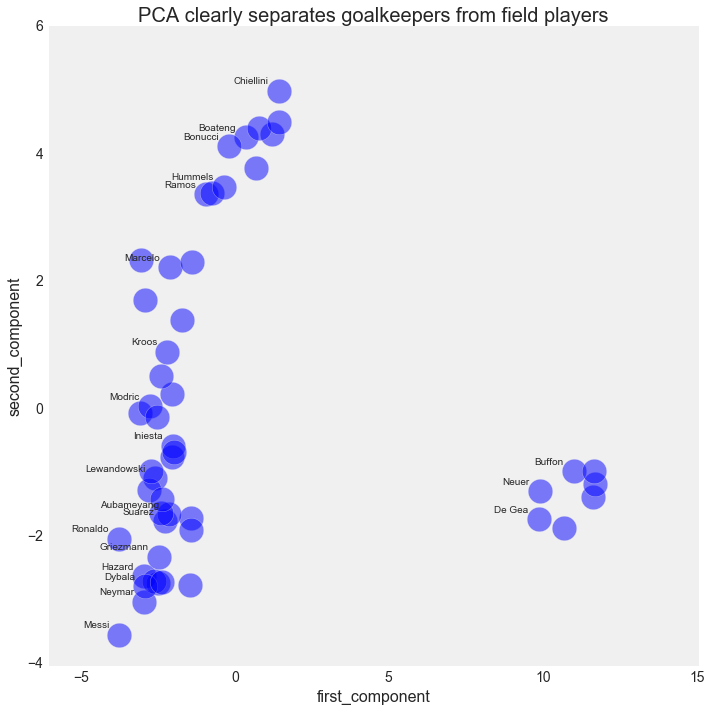

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(final.first_component, final.second_component, s=600, alpha=0.5)

ax.set_title('PCA clearly separates goalkeepers from field players', size=20)
ax.set_xlabel('first_component', size=16)
ax.set_ylabel('second_component', size=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-6, 15)
ax.grid(False)

labels = ['Ronaldo', 'Messi', 'Neymar', 'Suarez', 'Neuer',
         'Lewandowski', 'De Gea', 'Hazard', 'Kroos',
         '', 'Ramos', '', 'Buffon', 'Chiellini',
         '', '', 'Modric', '', '', '', '', '',
         '', '', '', 'Hummels', 'Dybala', 'Boateng',
         'Bonucci', 'Aubameyang', '', 'Griezmann',
         '', 'Marcelo', 'Iniesta']

for label, x, y in zip(labels,
                       final.first_component,
                       final.second_component):
    ax.annotate(label, xy=(x, y), xytext=(-10, 5),
               textcoords='offset points', ha='right', va='bottom')
    
fig.tight_layout()
fig.savefig('C:/Users/aluz/Desktop/fifa-2018/blog/first_chart.jpeg',
            facecolor='w')

Remember we had 7 goalkeepers in the top 50? They are those 7 dots at the bottom right corner of the scatterplot!

It looks like the first component is differentiating between field players and goalkeepers, and the second component is differentiating the field players themselves. We'll try removing the goalkeepers from the data set to be able to have 2 components that differentiate field players.

In [42]:
final.loc[final.first_component > 5, :]

,Name,first_component,second_component
4,M. Neuer,9.897268,-1.286419
6,De Gea,9.867425,-1.727868
12,G. Buffon,11.002236,-0.980031
17,T. Courtois,11.643721,-1.390708
23,H. Lloris,10.695054,-1.867871
32,J. Oblak,11.703517,-1.172635
36,S. Handanovič,11.650679,-0.970628


# Field players

In [43]:
field_players = final.loc[final.first_component < 5, :]

field_players.shape

(43, 3)

In [44]:
field_players.head(35)

,Name,first_component,second_component
0,Cristiano Ronaldo,-3.761511,-2.036917
1,L. Messi,-3.757096,-3.545738
2,Neymar,-2.950539,-3.023971
3,L. Suárez,-2.278626,-1.762801
5,R. Lewandowski,-2.582064,-1.083493
7,E. Hazard,-2.967642,-2.622033
8,T. Kroos,-2.199660,0.897233
9,G. Higuaín,-1.434195,-1.716591
10,Sergio Ramos,-0.939555,3.364601
11,G. Bale,-3.081380,-0.068234


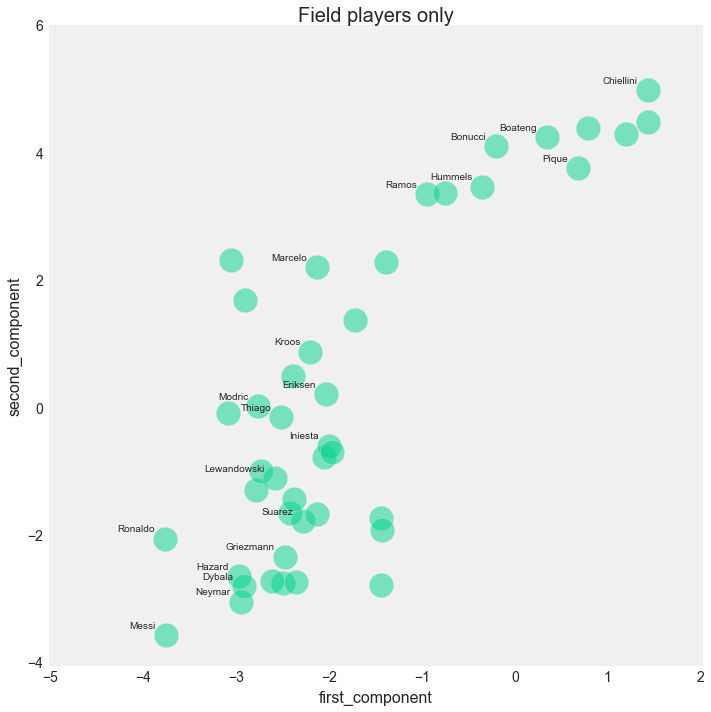

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(field_players.first_component, field_players.second_component, s=600,
           alpha=0.5, c='#00D48A')

ax.set_title('Field players only', size=20)
ax.set_xlabel('first_component', size=16)
ax.set_ylabel('second_component', size=16)
ax.tick_params(labelsize=14)
ax.grid(False)

labels = ['Ronaldo', 'Messi', 'Neymar', 'Suarez',
         'Lewandowski', 'Hazard', 'Kroos',
         '', 'Ramos', '', 'Chiellini',
         '', '', 'Modric', '', '', '', '',
         '', '', 'Hummels', 'Dybala', 'Boateng',
         'Bonucci', '', 'Thiago', 'Griezmann',
         'Marcelo', 'Iniesta', 'Pique', '', 'Eriksen']

for label, x, y in zip(labels,
                       field_players.first_component,
                       field_players.second_component):
    ax.annotate(label, xy=(x, y), xytext=(-10, 5),
               textcoords='offset points', ha='right', va='bottom')
    
fig.tight_layout()
fig.savefig('C:/Users/aluz/Desktop/fifa-2018/blog/second_chart.jpeg',
            facecolor='w')

In [46]:
field_players.loc[field_players.second_component > 4, :]

,Name,first_component,second_component
13,G. Chiellini,1.431848,4.994814
19,D. Godín,1.193964,4.309014
27,J. Boateng,0.347449,4.264559
28,L. Bonucci,-0.201393,4.121030
46,Javi Martínez,0.791725,4.405209
49,Sokratis,1.431789,4.495545


In [47]:
field_players.loc[field_players.second_component < -2, :]

,Name,first_component,second_component
0,Cristiano Ronaldo,-3.761511,-2.036917
1,L. Messi,-3.757096,-3.545738
2,Neymar,-2.950539,-3.023971
7,E. Hazard,-2.967642,-2.622033
14,S. Agüero,-2.498369,-2.734737
20,A. Robben,-2.617627,-2.699175
24,M. Özil,-1.443809,-2.758660
26,P. Dybala,-2.918887,-2.785933
31,A. Griezmann,-2.472937,-2.319025
48,D. Mertens,-2.355838,-2.723243


In [48]:
field_players.loc[field_players.first_component < -3, :]

,Name,first_component,second_component
0,Cristiano Ronaldo,-3.761511,-2.036917
1,L. Messi,-3.757096,-3.545738
11,G. Bale,-3.081380,-0.068234
40,A. Vidal,-3.053594,2.336861


In [49]:
field_players.loc[(field_players.first_component.between(-3, -2)) &
                  (field_players.second_component.between(-1, 1)), :]

,Name,first_component,second_component
8,T. Kroos,-2.199660,0.897233
16,L. Modrić,-2.759655,0.044246
18,K. De Bruyne,-2.730006,-0.977327
21,Z. Ibrahimović,-2.056936,-0.759104
30,Thiago,-2.513871,-0.133338
34,Iniesta,-2.002499,-0.578318
38,I. Rakitić,-2.036358,0.228841
39,M. Hamšík,-2.391333,0.521901


# Top 500 players

In [50]:
abilities = fifa.loc[fifa.index < 500, 'Acceleration':'Volleys'].copy()

In [51]:
abilities = pd.merge(fifa[['Name']], abilities, left_index=True, right_index=True)
abilities.sort_index(inplace=True)
abilities.sample(n=15)

,Name,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
179,L. Piszczek,73,83,66,66,76,82,86,80,74,...,82,78,77,83,84,79,84,79,72,67
205,K. Baldé Diao,93,54,82,77,89,79,75,70,87,...,76,76,78,28,92,73,29,76,73,68
399,J. Brandt,79,42,81,75,83,59,74,69,87,...,78,81,77,24,83,68,20,65,83,66
182,K. Schmeichel,62,33,62,47,40,52,18,13,12,...,80,44,36,13,60,35,14,62,59,15
464,Sidnei,42,77,51,45,76,71,56,36,69,...,75,71,61,79,58,69,82,90,44,43
36,C. Eriksen,77,44,78,82,87,87,86,85,84,...,83,89,80,22,74,90,56,57,90,74
284,A. Williams,62,83,58,59,66,73,32,34,57,...,80,71,64,80,67,70,84,86,53,34
258,G. Sigurðsson,65,57,72,61,84,81,86,87,79,...,78,84,82,55,66,86,56,67,84,75
59,R. Nainggolan,80,88,81,84,85,85,73,73,80,...,87,84,84,88,76,94,86,76,76,75
482,D. Wass,73,59,78,59,81,71,78,79,80,...,82,82,86,68,76,90,67,68,80,69


In [52]:
X = abilities.loc[:, 'Acceleration':].copy()

In [53]:
X.shape

(500, 34)

In [54]:
X.columns

Index([u'Acceleration', u'Aggression', u'Agility', u'Balance', u'Ball control',
       u'Composure', u'Crossing', u'Curve', u'Dribbling', u'Finishing',
       u'Free kick accuracy', u'GK diving', u'GK handling', u'GK kicking',
       u'GK positioning', u'GK reflexes', u'Heading accuracy',
       u'Interceptions', u'Jumping', u'Long passing', u'Long shots',
       u'Marking', u'Penalties', u'Positioning', u'Reactions',
       u'Short passing', u'Shot power', u'Sliding tackle', u'Sprint speed',
       u'Stamina', u'Standing tackle', u'Strength', u'Vision', u'Volleys'],
      dtype='object')

In [55]:
X_transformed = pipe.fit_transform(X)

In [56]:
pipe.named_steps['decomposition'].explained_variance_ratio_

array([ 0.58422189,  0.1829003 ])

In [57]:
X_transformed.shape

(500L, 2L)

In [58]:
final = pd.DataFrame(X_transformed, columns=['first_component', 'second_component'])
final.head()

,first_component,second_component
0,-4.386718,-2.533557
1,-4.396864,-4.403829
2,-3.666525,-3.969918
3,-2.872107,-2.367860
4,10.078671,-1.637535


In [59]:
final = pd.merge(fifa[['Name', 'Overall', 'Preferred Position']], final,
                 left_index=True, right_index=True)
final.head()

,Name,Overall,Preferred Position,first_component,second_component
0,Cristiano Ronaldo,94,A,-4.386718,-2.533557
1,L. Messi,93,A,-4.396864,-4.403829
2,Neymar,92,A,-3.666525,-3.969918
3,L. Suárez,92,A,-2.872107,-2.367860
4,M. Neuer,92,GK,10.078671,-1.637535


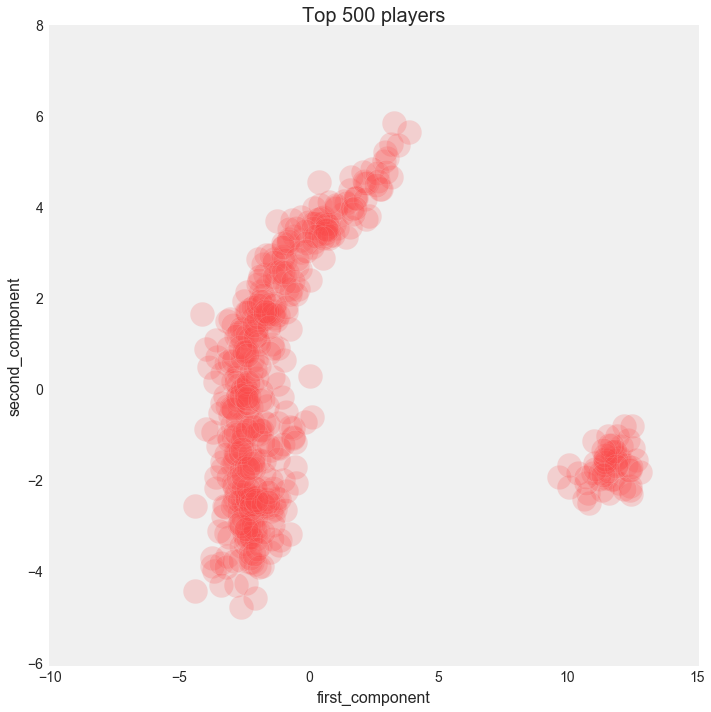

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(final.first_component, final.second_component, s=600,
           alpha=0.2, c='#FF4B4B')

ax.set_title('Top 500 players', size=20)
ax.set_xlabel('first_component', size=16)
ax.set_ylabel('second_component', size=16)
ax.tick_params(labelsize=14)
ax.grid(False)

fig.tight_layout()
fig.savefig('C:/Users/aluz/Desktop/fifa-2018/blog/third_chart.jpeg',
            facecolor='w')

In [61]:
final.loc[(final.first_component < -5) &
          (final.second_component > 4), :]

,Name,Overall,Preferred Position,first_component,second_component


In [62]:
final.loc[final.second_component < -5, :]

,Name,Overall,Preferred Position,first_component,second_component


In [63]:
final.loc[final.first_component > 5, :]

,Name,Overall,Preferred Position,first_component,second_component
4,M. Neuer,92,GK,10.078671,-1.637535
6,De Gea,90,GK,10.042162,-2.122686
12,T. Courtois,89,GK,11.716111,-1.944549
18,G. Buffon,89,GK,11.066032,-1.599183
20,J. Oblak,88,GK,11.874967,-1.616716
29,H. Lloris,88,GK,10.786103,-2.257851
43,S. Handanovič,87,GK,11.756124,-1.354296
68,P. Čech,86,GK,11.745171,-1.940033
74,K. Navas,85,GK,11.475550,-1.912915
76,D. Subašić,85,GK,11.521134,-1.527831


# Field players

In [64]:
field_players = final.loc[final.first_component < 5, :]

field_players.shape

(442, 5)

In [65]:
field_players.head()

,Name,Overall,Preferred Position,first_component,second_component
0,Cristiano Ronaldo,94,A,-4.386718,-2.533557
1,L. Messi,93,A,-4.396864,-4.403829
2,Neymar,92,A,-3.666525,-3.969918
3,L. Suárez,92,A,-2.872107,-2.367860
5,R. Lewandowski,91,A,-3.346013,-1.733359


In [66]:
field_players['Preferred Position'].unique()

array(['A', 'DM', 'D', 'AM'], dtype=object)

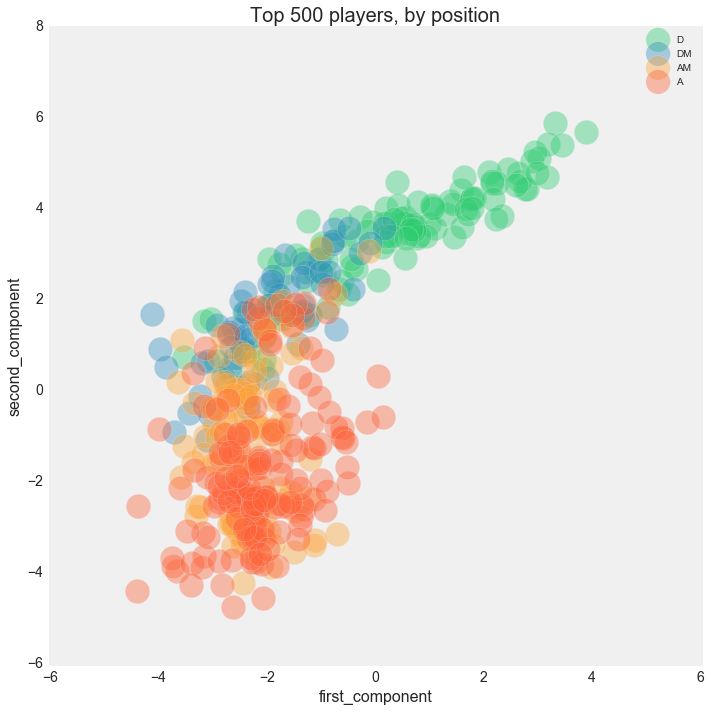

In [67]:
#field_players['Preferred Position'].unique()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

colours = ['#2ECC71', '#3290BE', '#FFA339', '#FF6239']
for i, pos in enumerate(['D', 'DM', 'AM', 'A']):
    temp = field_players.loc[field_players['Preferred Position'] == pos, :].copy()
    ax.scatter(temp.first_component, temp.second_component, s=600,
               alpha=0.4, c=colours[i], label=pos)

ax.set_title('Top 500 players, by position', size=20)
ax.set_xlabel('first_component', size=16)
ax.set_ylabel('second_component', size=16)
ax.tick_params(labelsize=14)
ax.legend()
ax.grid(False)

fig.tight_layout()
fig.savefig('C:/Users/aluz/Desktop/fifa-2018/blog/fourth_chart.jpeg',
            facecolor='w')

In [68]:
field_players.loc[(field_players.first_component < -4) &
                  (field_players.second_component < 6), :]

,Name,Overall,Preferred Position,first_component,second_component
0,Cristiano Ronaldo,94,A,-4.386718,-2.533557
1,L. Messi,93,A,-4.396864,-4.403829
37,A. Vidal,87,DM,-4.128512,1.685953


In [69]:
field_players.loc[field_players.second_component > 4, :]

,Name,Overall,Preferred Position,first_component,second_component
17,G. Chiellini,89,D,0.402176,4.593237
26,D. Godín,88,D,0.199254,4.003492
62,Sokratis,86,D,0.419432,4.069365
67,Pepe,86,D,1.044190,4.038532
79,K. Glik,85,D,3.306493,5.878030
91,A. Barzagli,85,D,1.374262,4.157361
102,K. Koulibaly,84,D,3.187376,5.414179
105,K. Manolas,84,D,3.025615,5.105460
119,M. Benatia,84,D,1.578968,4.404174
130,J. Giménez,83,D,2.099958,4.804673


In [70]:
field_players.loc[field_players.second_component < -5, :]

,Name,Overall,Preferred Position,first_component,second_component


In [71]:
field_players.loc[field_players.first_component < -4, :]

,Name,Overall,Preferred Position,first_component,second_component
0,Cristiano Ronaldo,94,A,-4.386718,-2.533557
1,L. Messi,93,A,-4.396864,-4.403829
37,A. Vidal,87,DM,-4.128512,1.685953


In [72]:
field_players.loc[(field_players.first_component.between(-3, -2)) &
                  (field_players.second_component.between(-1, 1)), :]

,Name,Overall,Preferred Position,first_component,second_component
34,M. Verratti,87,DM,-2.687584,0.521434
46,H. Kane,86,A,-2.364058,-0.885692
65,Cesc Fàbregas,86,AM,-2.971029,-0.747343
80,Jordi Alba,85,D,-2.682315,0.417396
96,D. Alli,84,AM,-2.920301,0.219655
104,Koke,84,AM,-2.693977,-0.357296
129,N. Keïta,83,AM,-2.195540,-0.672749
133,João Mário,83,AM,-2.576504,0.006071
157,Parejo,83,AM,-2.400342,-0.585676
171,A. Lallana,83,AM,-2.727047,-0.112064
